# 计算机视觉期末大作业 - 主题二：数据增强技术研究

**作者**：XX  
**日期**：2025年6月  

**简介**：  
本 Notebook 按照“主题二：数据增强技术的深度探索与对比评估”要求，实现了：
- 模型A（SimpleCNN）与模型B（ResNet-18）；
- 多种单一增强、组合增强，以及参数敏感性分析；
- 训练、评估、绘图与结果对比分析。

Notebook 结构如下：
1. 全局参数与环境检查  
2. 模型定义  
3. 数据增强变换定义  
4. 数据加载函数  
5. 训练与评估函数  
6. 可视化函数  
7. 主实验执行  
8. 参数敏感性分析  
9. 结果汇总与可视化  
10. 实验结论  

In [8]:
# ========== 2. 全局参数 & 环境检查 ==========
import torch
import numpy as np

# 为了实验可重复，固定随机种子
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 设备检查
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"==== 运行设备：{device} ====")

# 超参数
batch_size = 128
num_epochs = 30
learning_rate = 1e-3


==== 运行设备：cuda ====


In [9]:
# ========== 3. 模型定义 ==========

import torch.nn as nn
import torch.nn.functional as F
import torchvision
# 模型A：简单自定义CNN
class SimpleCNN(nn.Module):
    """
    简单的自定义CNN模型
    包含3个卷积层，每层后跟BatchNorm、ReLU和MaxPool
    最后连接全连接层进行分类
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)    # 输出 32 x 16 x 16
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)    # 输出 64 x 8 x 8
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)    # 输出 128 x 4 x 4
        
        self.fc1   = nn.Linear(128*4*4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2   = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
# 模型B：ResNet-18
def get_resnet18(num_classes=10):
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [10]:
# ========== 4. 数据增强变换定义 ==========

import torchvision.transforms as transforms

# 4.1 基线变换（Baseline）
def get_baseline_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

# 4.2 单一增强策略
def get_single_augmentation_transforms():
    base_norm = transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    return {
        'horizontal_flip': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(), base_norm
        ]),
        'rotation': transforms.Compose([
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(), base_norm
        ]),
        'random_crop': transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.8,1.0)),
            transforms.ToTensor(), base_norm
        ]),
        'color_jitter': transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(), base_norm
        ]),
        'random_erasing': transforms.Compose([
            transforms.ToTensor(), base_norm,
            transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.3,3.3))
        ])
    }

# 4.3 组合增强策略
def get_combination_augmentation_transforms():
    base_norm = transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    return {
        'geo_color_combo': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(), base_norm
        ]),
        'geo_erase_combo': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(32, scale=(0.8,1.0)),
            transforms.ToTensor(), base_norm,
            transforms.RandomErasing(p=0.3, scale=(0.02,0.25))
        ]),
        'comprehensive_combo': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.ToTensor(), base_norm,
            transforms.RandomErasing(p=0.2, scale=(0.02,0.2))
        ])
    }

# 4.4 参数敏感性（以旋转为例）
def get_parameter_sensitivity_transforms():
    base_norm = transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    return {
        'rotation_5deg': transforms.Compose([
            transforms.RandomRotation(5), transforms.ToTensor(), base_norm
        ]),
        'rotation_15deg': transforms.Compose([
            transforms.RandomRotation(15), transforms.ToTensor(), base_norm
        ]),
        'rotation_30deg': transforms.Compose([
            transforms.RandomRotation(30), transforms.ToTensor(), base_norm
        ])
    }


In [11]:
# ========== 5. 数据加载函数 ==========

from torch.utils.data import DataLoader
import torchvision.datasets as datasets

def get_cifar10_loaders(transform_train, transform_test, batch_size=128):
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

# CIFAR-10 类别
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')


In [12]:
# ========== 6. 训练与评估函数 ==========

import torch.optim as optim
import time, copy

def train_model(model, trainloader, testloader, num_epochs=30, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    best_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            running_correct += (preds==labels).sum().item()
            running_total += labels.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * running_correct / running_total

        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, preds = outputs.max(1)
                test_correct += (preds==labels).sum().item()
                test_total += labels.size(0)

        test_loss = test_loss / len(testloader)
        test_acc = 100. * test_correct / test_total

        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # 保存最佳模型
        if test_acc > best_acc:
            best_acc = test_acc
            best_state = copy.deepcopy(model.state_dict())

        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    # 加载最好权重
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"最佳测试准确率: {best_acc:.2f}%")
    return model, history

def evaluate_model(model, testloader):
    model.eval()
    total, correct = 0, 0
    class_correct = [0]*10
    class_total   = [0]*10
    start = time.time()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += (preds==labels).sum().item()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (preds[i]==labels[i]).item()
                class_total[label]   += 1

    inf_time = time.time() - start
    overall_acc = 100. * correct / total
    class_acc = {classes[i]:100.*class_correct[i]/class_total[i] for i in range(10) if class_total[i]>0}
    return {'overall_accuracy': overall_acc, 'class_accuracy': class_acc, 'inference_time': inf_time}


In [29]:
# ========== 7. 可视化函数 ==========

import matplotlib.pyplot as plt
# 设置全局「无衬线」字体列表为 DejaVu Sans 或 Arial（系统大多数环境都有）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
# 如果想把默认的字体改为无衬线
plt.rcParams['font.family'] = 'sans-serif'
# 避免负号 '-' 显示成方块
plt.rcParams['axes.unicode_minus'] = False

def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_title(f"{title} - Loss")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
    ax1.legend(); ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['test_acc'], label='Test Acc')
    ax2.set_title(f"{title} - Accuracy")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy (%)")
    ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_augmentation_comparison(df, model_name):
    plt.figure(figsize=(10,6))
    plt.bar(df['augmentation'], df['accuracy'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{model_name} - Accuracy rate comparison")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Augmentation")
    plt.grid(alpha=0.3)
    plt.show()



====== 训练 & 评估: SimpleCNN ======

>> 实验: baseline
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 49.27% | Test Acc: 63.81%
Epoch 2/30 | Train Acc: 63.49% | Test Acc: 66.77%
Epoch 3/30 | Train Acc: 68.30% | Test Acc: 68.58%
Epoch 4/30 | Train Acc: 71.45% | Test Acc: 73.76%
Epoch 5/30 | Train Acc: 73.76% | Test Acc: 74.66%
Epoch 6/30 | Train Acc: 75.56% | Test Acc: 75.68%
Epoch 7/30 | Train Acc: 77.60% | Test Acc: 76.48%
Epoch 8/30 | Train Acc: 79.06% | Test Acc: 77.74%
Epoch 9/30 | Train Acc: 80.45% | Test Acc: 79.01%
Epoch 10/30 | Train Acc: 81.49% | Test Acc: 76.23%
Epoch 11/30 | Train Acc: 82.92% | Test Acc: 78.24%
Epoch 12/30 | Train Acc: 84.14% | Test Acc: 78.27%
Epoch 13/30 | Train Acc: 85.22% | Test Acc: 79.57%
Epoch 14/30 | Train Acc: 85.97% | Test Acc: 78.96%
Epoch 15/30 | Train Acc: 86.66% | Test Acc: 79.67%
Epoch 16/30 | Train Acc: 87.34% | Test Acc: 79.61%
Epoch 17/30 | Train Acc: 88.43% | Test Acc: 79.59%
Epoch 18/30 | T

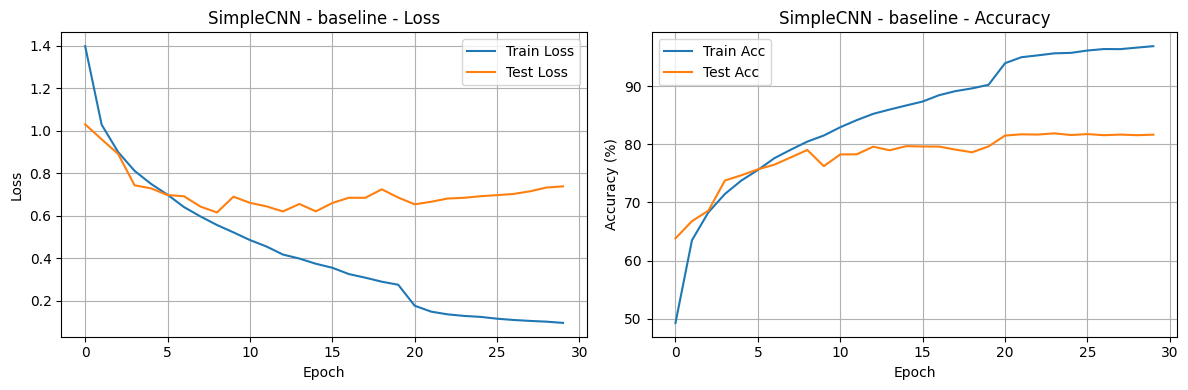


>> 实验: horizontal_flip
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 48.26% | Test Acc: 60.82%
Epoch 2/30 | Train Acc: 63.21% | Test Acc: 68.17%
Epoch 3/30 | Train Acc: 67.77% | Test Acc: 71.23%
Epoch 4/30 | Train Acc: 70.65% | Test Acc: 71.97%
Epoch 5/30 | Train Acc: 72.58% | Test Acc: 74.58%
Epoch 6/30 | Train Acc: 74.27% | Test Acc: 74.11%
Epoch 7/30 | Train Acc: 75.61% | Test Acc: 77.24%
Epoch 8/30 | Train Acc: 76.72% | Test Acc: 76.22%
Epoch 9/30 | Train Acc: 78.02% | Test Acc: 76.55%
Epoch 10/30 | Train Acc: 79.01% | Test Acc: 78.52%
Epoch 11/30 | Train Acc: 79.89% | Test Acc: 79.20%
Epoch 12/30 | Train Acc: 80.40% | Test Acc: 78.72%
Epoch 13/30 | Train Acc: 81.45% | Test Acc: 79.42%
Epoch 14/30 | Train Acc: 82.12% | Test Acc: 79.58%
Epoch 15/30 | Train Acc: 82.62% | Test Acc: 79.24%
Epoch 16/30 | Train Acc: 83.41% | Test Acc: 80.72%
Epoch 17/30 | Train Acc: 83.79% | Test Acc: 79.98%
Epoch 18/30 | Train Acc: 84.28% | Test Acc

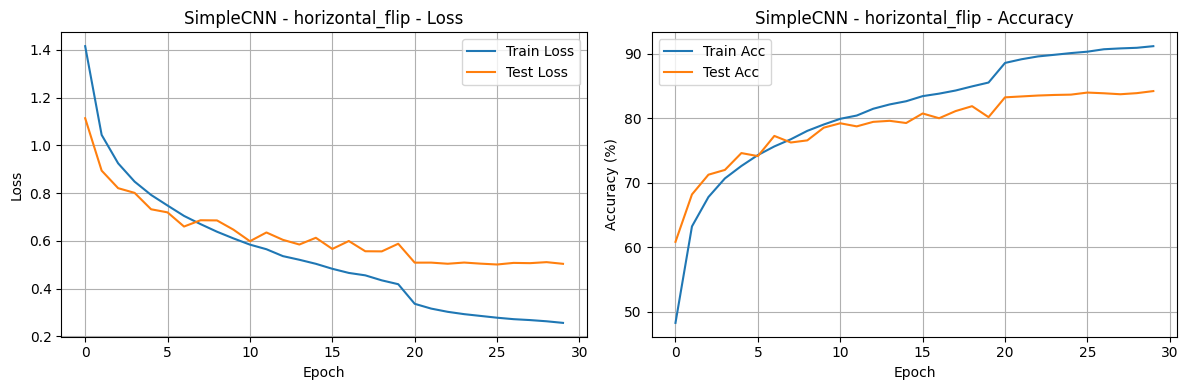


>> 实验: rotation
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 45.62% | Test Acc: 58.51%
Epoch 2/30 | Train Acc: 58.76% | Test Acc: 66.86%
Epoch 3/30 | Train Acc: 63.49% | Test Acc: 68.48%
Epoch 4/30 | Train Acc: 66.14% | Test Acc: 72.38%
Epoch 5/30 | Train Acc: 68.21% | Test Acc: 73.81%
Epoch 6/30 | Train Acc: 69.80% | Test Acc: 75.28%
Epoch 7/30 | Train Acc: 71.58% | Test Acc: 75.28%
Epoch 8/30 | Train Acc: 72.53% | Test Acc: 75.47%
Epoch 9/30 | Train Acc: 73.54% | Test Acc: 77.01%
Epoch 10/30 | Train Acc: 74.44% | Test Acc: 76.23%
Epoch 11/30 | Train Acc: 75.46% | Test Acc: 77.75%
Epoch 12/30 | Train Acc: 76.04% | Test Acc: 78.55%
Epoch 13/30 | Train Acc: 76.73% | Test Acc: 78.65%
Epoch 14/30 | Train Acc: 77.71% | Test Acc: 79.81%
Epoch 15/30 | Train Acc: 78.13% | Test Acc: 79.27%
Epoch 16/30 | Train Acc: 78.55% | Test Acc: 79.60%
Epoch 17/30 | Train Acc: 79.02% | Test Acc: 79.57%
Epoch 18/30 | Train Acc: 79.61% | Test Acc: 80.36

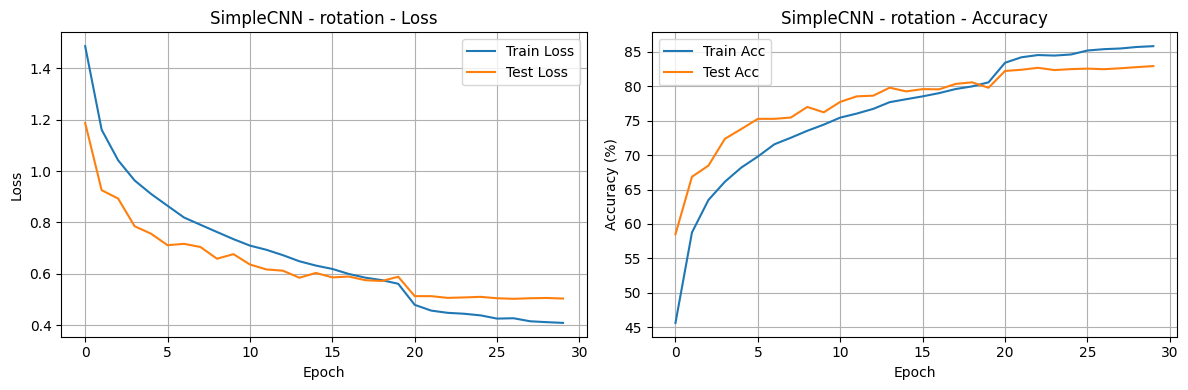


>> 实验: random_crop
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 46.01% | Test Acc: 59.68%
Epoch 2/30 | Train Acc: 59.31% | Test Acc: 65.05%
Epoch 3/30 | Train Acc: 64.11% | Test Acc: 69.56%
Epoch 4/30 | Train Acc: 66.95% | Test Acc: 69.81%
Epoch 5/30 | Train Acc: 69.38% | Test Acc: 70.49%
Epoch 6/30 | Train Acc: 71.08% | Test Acc: 74.17%
Epoch 7/30 | Train Acc: 72.73% | Test Acc: 75.43%
Epoch 8/30 | Train Acc: 73.87% | Test Acc: 76.43%
Epoch 9/30 | Train Acc: 75.16% | Test Acc: 76.17%
Epoch 10/30 | Train Acc: 76.16% | Test Acc: 76.30%
Epoch 11/30 | Train Acc: 76.68% | Test Acc: 76.34%
Epoch 12/30 | Train Acc: 77.45% | Test Acc: 79.15%
Epoch 13/30 | Train Acc: 78.20% | Test Acc: 77.16%
Epoch 14/30 | Train Acc: 78.99% | Test Acc: 79.25%
Epoch 15/30 | Train Acc: 79.37% | Test Acc: 78.70%
Epoch 16/30 | Train Acc: 80.30% | Test Acc: 79.45%
Epoch 17/30 | Train Acc: 80.81% | Test Acc: 79.26%
Epoch 18/30 | Train Acc: 80.88% | Test Acc: 78

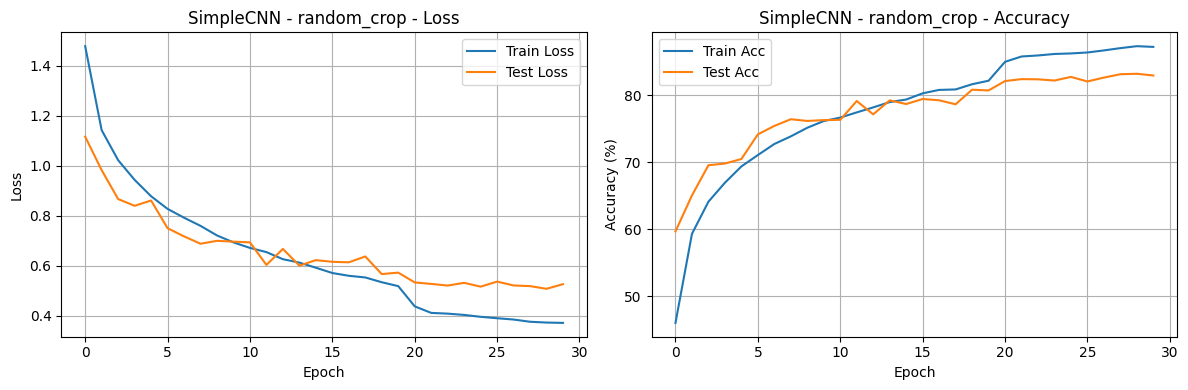


>> 实验: color_jitter
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 48.11% | Test Acc: 59.63%
Epoch 2/30 | Train Acc: 62.14% | Test Acc: 69.21%
Epoch 3/30 | Train Acc: 67.45% | Test Acc: 70.86%
Epoch 4/30 | Train Acc: 70.25% | Test Acc: 72.61%
Epoch 5/30 | Train Acc: 72.92% | Test Acc: 73.51%
Epoch 6/30 | Train Acc: 74.82% | Test Acc: 74.85%
Epoch 7/30 | Train Acc: 76.42% | Test Acc: 75.87%
Epoch 8/30 | Train Acc: 78.04% | Test Acc: 77.51%
Epoch 9/30 | Train Acc: 79.28% | Test Acc: 75.58%
Epoch 10/30 | Train Acc: 80.61% | Test Acc: 77.59%
Epoch 11/30 | Train Acc: 81.72% | Test Acc: 77.98%
Epoch 12/30 | Train Acc: 82.74% | Test Acc: 76.98%
Epoch 13/30 | Train Acc: 83.63% | Test Acc: 77.57%
Epoch 14/30 | Train Acc: 84.95% | Test Acc: 78.64%
Epoch 15/30 | Train Acc: 85.87% | Test Acc: 79.36%
Epoch 16/30 | Train Acc: 86.60% | Test Acc: 79.63%
Epoch 17/30 | Train Acc: 87.26% | Test Acc: 79.48%
Epoch 18/30 | Train Acc: 87.72% | Test Acc: 7

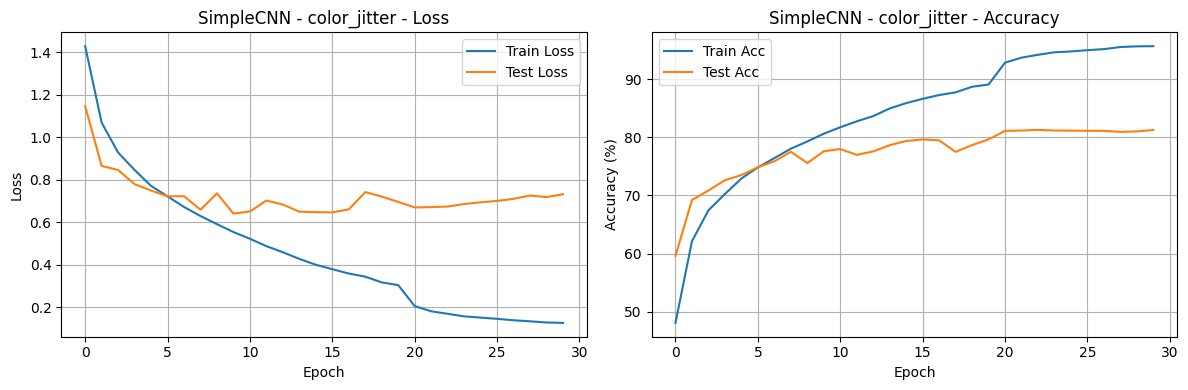


>> 实验: random_erasing
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 45.19% | Test Acc: 59.26%
Epoch 2/30 | Train Acc: 57.98% | Test Acc: 65.52%
Epoch 3/30 | Train Acc: 63.01% | Test Acc: 68.29%
Epoch 4/30 | Train Acc: 65.56% | Test Acc: 70.52%
Epoch 5/30 | Train Acc: 67.42% | Test Acc: 72.38%
Epoch 6/30 | Train Acc: 69.40% | Test Acc: 73.85%
Epoch 7/30 | Train Acc: 70.72% | Test Acc: 74.79%
Epoch 8/30 | Train Acc: 72.18% | Test Acc: 76.09%
Epoch 9/30 | Train Acc: 72.95% | Test Acc: 73.86%
Epoch 10/30 | Train Acc: 74.64% | Test Acc: 76.42%
Epoch 11/30 | Train Acc: 75.29% | Test Acc: 77.36%
Epoch 12/30 | Train Acc: 76.07% | Test Acc: 77.61%
Epoch 13/30 | Train Acc: 76.98% | Test Acc: 78.71%
Epoch 14/30 | Train Acc: 77.62% | Test Acc: 78.38%
Epoch 15/30 | Train Acc: 78.41% | Test Acc: 77.85%
Epoch 16/30 | Train Acc: 78.93% | Test Acc: 77.66%
Epoch 17/30 | Train Acc: 79.55% | Test Acc: 79.72%
Epoch 18/30 | Train Acc: 79.97% | Test Acc:

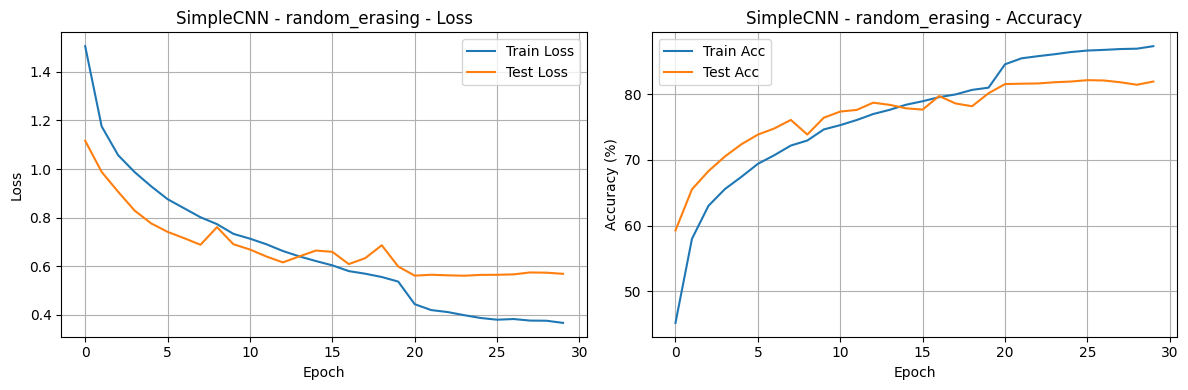


>> 实验: geo_color_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 45.75% | Test Acc: 59.72%
Epoch 2/30 | Train Acc: 59.08% | Test Acc: 65.16%
Epoch 3/30 | Train Acc: 64.11% | Test Acc: 70.86%
Epoch 4/30 | Train Acc: 66.87% | Test Acc: 70.50%
Epoch 5/30 | Train Acc: 68.53% | Test Acc: 73.12%
Epoch 6/30 | Train Acc: 69.92% | Test Acc: 74.28%
Epoch 7/30 | Train Acc: 71.32% | Test Acc: 75.11%
Epoch 8/30 | Train Acc: 72.53% | Test Acc: 75.74%
Epoch 9/30 | Train Acc: 73.64% | Test Acc: 77.70%
Epoch 10/30 | Train Acc: 74.39% | Test Acc: 76.68%
Epoch 11/30 | Train Acc: 75.43% | Test Acc: 78.76%
Epoch 12/30 | Train Acc: 75.86% | Test Acc: 79.86%
Epoch 13/30 | Train Acc: 76.65% | Test Acc: 78.95%
Epoch 14/30 | Train Acc: 77.16% | Test Acc: 80.22%
Epoch 15/30 | Train Acc: 77.65% | Test Acc: 77.85%
Epoch 16/30 | Train Acc: 78.10% | Test Acc: 79.71%
Epoch 17/30 | Train Acc: 78.76% | Test Acc: 80.42%
Epoch 18/30 | Train Acc: 79.02% | Test Acc

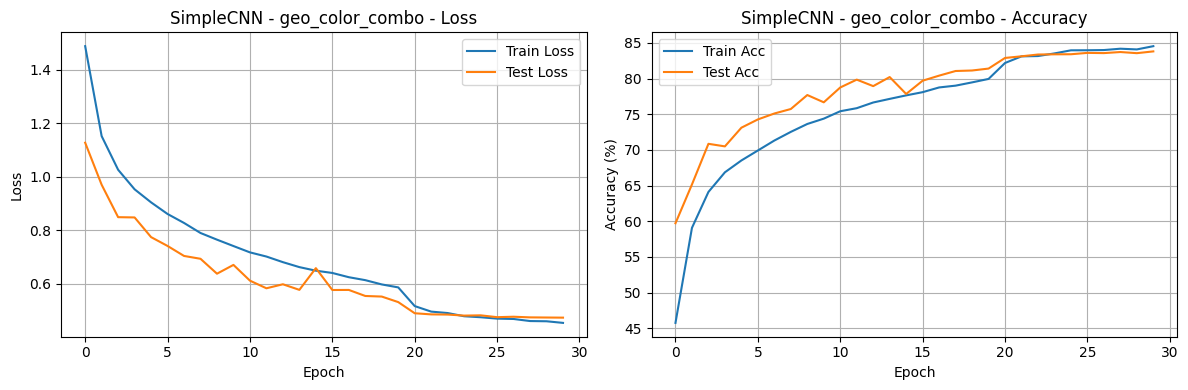


>> 实验: geo_erase_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 43.74% | Test Acc: 58.83%
Epoch 2/30 | Train Acc: 55.91% | Test Acc: 59.58%
Epoch 3/30 | Train Acc: 60.62% | Test Acc: 64.88%
Epoch 4/30 | Train Acc: 63.24% | Test Acc: 70.26%
Epoch 5/30 | Train Acc: 65.34% | Test Acc: 70.52%
Epoch 6/30 | Train Acc: 67.18% | Test Acc: 70.73%
Epoch 7/30 | Train Acc: 68.22% | Test Acc: 73.83%
Epoch 8/30 | Train Acc: 69.54% | Test Acc: 74.67%
Epoch 9/30 | Train Acc: 70.37% | Test Acc: 75.15%
Epoch 10/30 | Train Acc: 71.38% | Test Acc: 75.28%
Epoch 11/30 | Train Acc: 72.01% | Test Acc: 76.64%
Epoch 12/30 | Train Acc: 72.79% | Test Acc: 76.05%
Epoch 13/30 | Train Acc: 73.61% | Test Acc: 76.95%
Epoch 14/30 | Train Acc: 73.83% | Test Acc: 75.79%
Epoch 15/30 | Train Acc: 74.43% | Test Acc: 76.21%
Epoch 16/30 | Train Acc: 75.11% | Test Acc: 78.22%
Epoch 17/30 | Train Acc: 75.42% | Test Acc: 78.13%
Epoch 18/30 | Train Acc: 75.74% | Test Acc

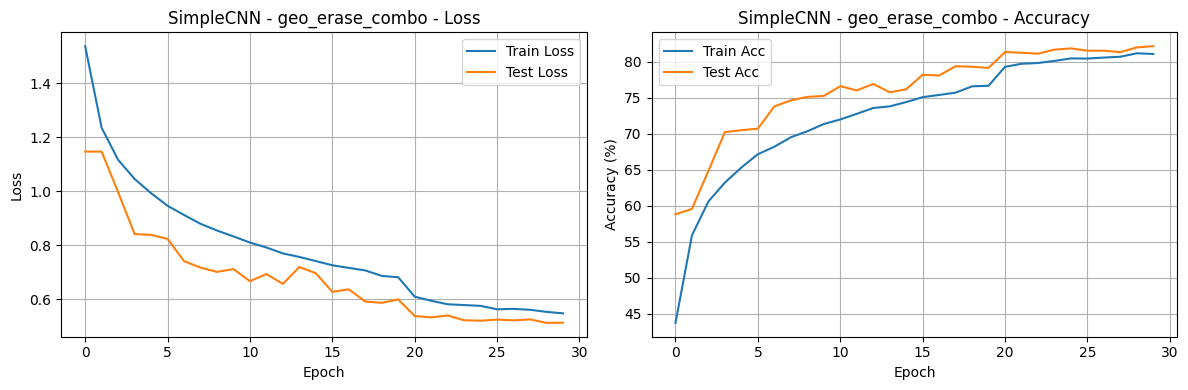


>> 实验: comprehensive_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 41.30% | Test Acc: 56.63%
Epoch 2/30 | Train Acc: 53.91% | Test Acc: 62.77%
Epoch 3/30 | Train Acc: 58.41% | Test Acc: 66.28%
Epoch 4/30 | Train Acc: 61.16% | Test Acc: 68.70%
Epoch 5/30 | Train Acc: 63.33% | Test Acc: 70.02%
Epoch 6/30 | Train Acc: 65.15% | Test Acc: 71.44%
Epoch 7/30 | Train Acc: 66.38% | Test Acc: 74.47%
Epoch 8/30 | Train Acc: 67.34% | Test Acc: 75.69%
Epoch 9/30 | Train Acc: 68.39% | Test Acc: 73.46%
Epoch 10/30 | Train Acc: 69.14% | Test Acc: 75.94%
Epoch 11/30 | Train Acc: 70.01% | Test Acc: 76.82%
Epoch 12/30 | Train Acc: 70.57% | Test Acc: 77.87%
Epoch 13/30 | Train Acc: 71.29% | Test Acc: 77.67%
Epoch 14/30 | Train Acc: 71.33% | Test Acc: 77.56%
Epoch 15/30 | Train Acc: 72.66% | Test Acc: 77.80%
Epoch 16/30 | Train Acc: 72.47% | Test Acc: 78.13%
Epoch 17/30 | Train Acc: 73.02% | Test Acc: 78.72%
Epoch 18/30 | Train Acc: 73.68% | Test

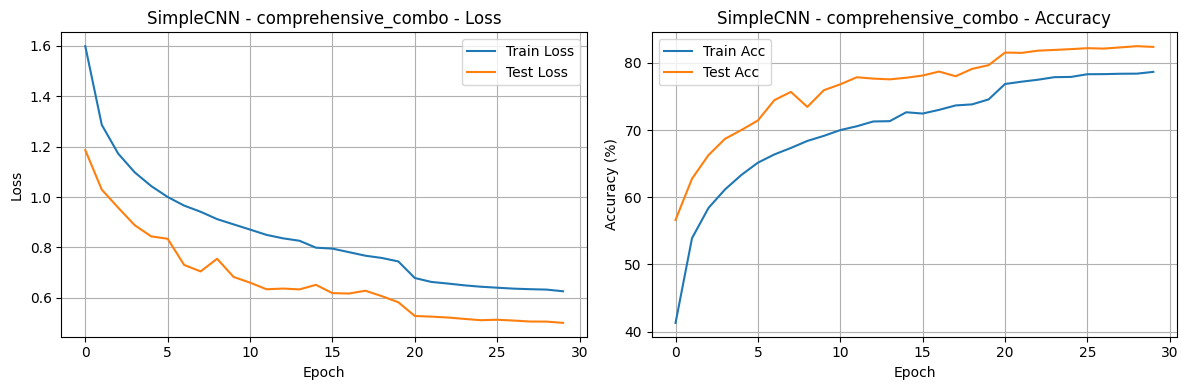


====== 训练 & 评估: ResNet-18 ======

>> 实验: baseline
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 50.91% | Test Acc: 58.02%
Epoch 2/30 | Train Acc: 65.59% | Test Acc: 66.94%
Epoch 3/30 | Train Acc: 71.97% | Test Acc: 67.77%
Epoch 4/30 | Train Acc: 76.18% | Test Acc: 72.08%
Epoch 5/30 | Train Acc: 79.83% | Test Acc: 73.27%
Epoch 6/30 | Train Acc: 82.75% | Test Acc: 72.87%
Epoch 7/30 | Train Acc: 85.40% | Test Acc: 74.04%
Epoch 8/30 | Train Acc: 87.32% | Test Acc: 74.61%
Epoch 9/30 | Train Acc: 89.62% | Test Acc: 74.14%
Epoch 10/30 | Train Acc: 91.32% | Test Acc: 74.44%
Epoch 11/30 | Train Acc: 92.62% | Test Acc: 74.40%
Epoch 12/30 | Train Acc: 93.54% | Test Acc: 74.70%
Epoch 13/30 | Train Acc: 94.27% | Test Acc: 73.96%
Epoch 14/30 | Train Acc: 94.76% | Test Acc: 75.14%
Epoch 15/30 | Train Acc: 95.51% | Test Acc: 74.72%
Epoch 16/30 | Train Acc: 95.42% | Test Acc: 74.55%
Epoch 17/30 | Train Acc: 95.93% | Test Acc: 75.41%
Epoch 18/30 | T

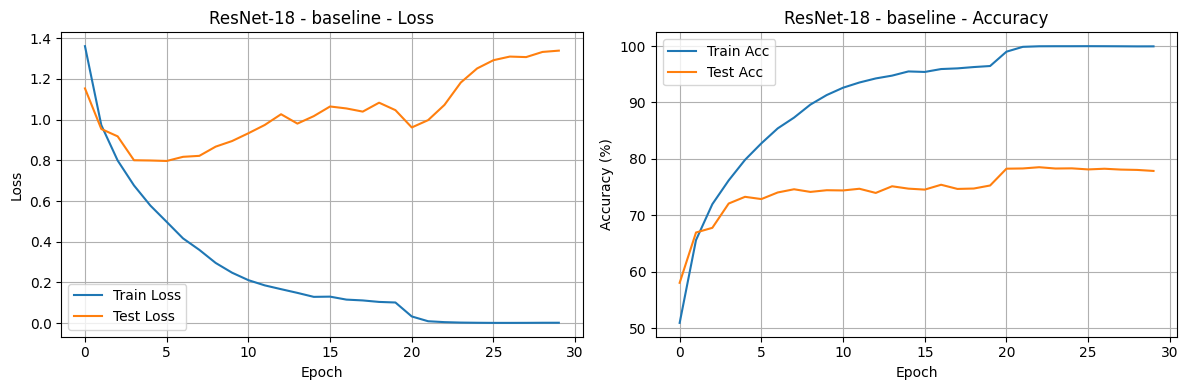


>> 实验: horizontal_flip
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 50.99% | Test Acc: 58.69%
Epoch 2/30 | Train Acc: 64.98% | Test Acc: 66.99%
Epoch 3/30 | Train Acc: 70.90% | Test Acc: 70.08%
Epoch 4/30 | Train Acc: 74.16% | Test Acc: 72.54%
Epoch 5/30 | Train Acc: 77.17% | Test Acc: 73.46%
Epoch 6/30 | Train Acc: 79.24% | Test Acc: 73.69%
Epoch 7/30 | Train Acc: 80.81% | Test Acc: 76.15%
Epoch 8/30 | Train Acc: 82.33% | Test Acc: 76.18%
Epoch 9/30 | Train Acc: 83.56% | Test Acc: 78.35%
Epoch 10/30 | Train Acc: 84.97% | Test Acc: 76.50%
Epoch 11/30 | Train Acc: 85.94% | Test Acc: 75.75%
Epoch 12/30 | Train Acc: 87.07% | Test Acc: 77.06%
Epoch 13/30 | Train Acc: 87.85% | Test Acc: 78.81%
Epoch 14/30 | Train Acc: 88.66% | Test Acc: 79.48%
Epoch 15/30 | Train Acc: 89.44% | Test Acc: 78.48%
Epoch 16/30 | Train Acc: 90.09% | Test Acc: 78.70%
Epoch 17/30 | Train Acc: 90.74% | Test Acc: 78.50%
Epoch 18/30 | Train Acc: 91.40% | Test Acc

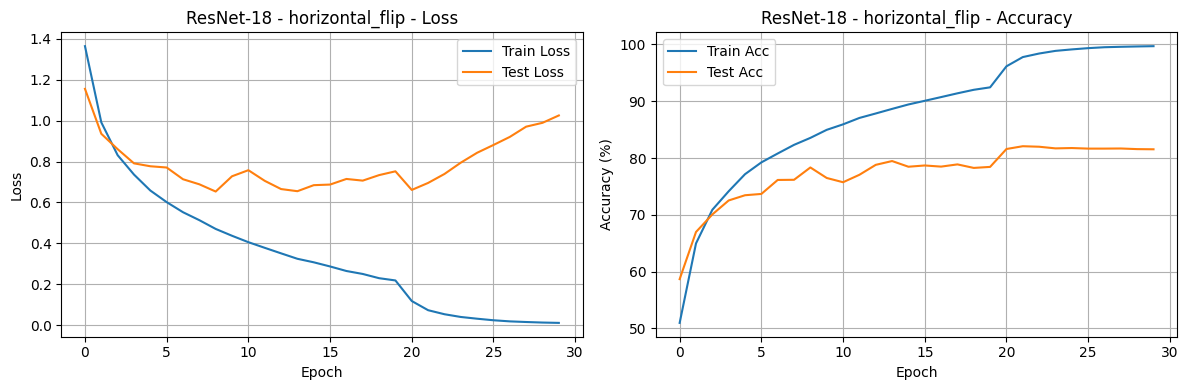


>> 实验: rotation
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 47.61% | Test Acc: 56.96%
Epoch 2/30 | Train Acc: 60.60% | Test Acc: 62.67%
Epoch 3/30 | Train Acc: 66.77% | Test Acc: 68.49%
Epoch 4/30 | Train Acc: 70.65% | Test Acc: 71.36%
Epoch 5/30 | Train Acc: 73.16% | Test Acc: 71.82%
Epoch 6/30 | Train Acc: 75.00% | Test Acc: 72.46%
Epoch 7/30 | Train Acc: 77.40% | Test Acc: 73.39%
Epoch 8/30 | Train Acc: 78.93% | Test Acc: 75.27%
Epoch 9/30 | Train Acc: 80.43% | Test Acc: 76.10%
Epoch 10/30 | Train Acc: 81.96% | Test Acc: 76.41%
Epoch 11/30 | Train Acc: 83.03% | Test Acc: 75.94%
Epoch 12/30 | Train Acc: 84.10% | Test Acc: 75.98%
Epoch 13/30 | Train Acc: 85.17% | Test Acc: 76.85%
Epoch 14/30 | Train Acc: 86.19% | Test Acc: 77.66%
Epoch 15/30 | Train Acc: 87.47% | Test Acc: 77.55%
Epoch 16/30 | Train Acc: 88.07% | Test Acc: 76.33%
Epoch 17/30 | Train Acc: 88.65% | Test Acc: 77.22%
Epoch 18/30 | Train Acc: 89.62% | Test Acc: 77.59

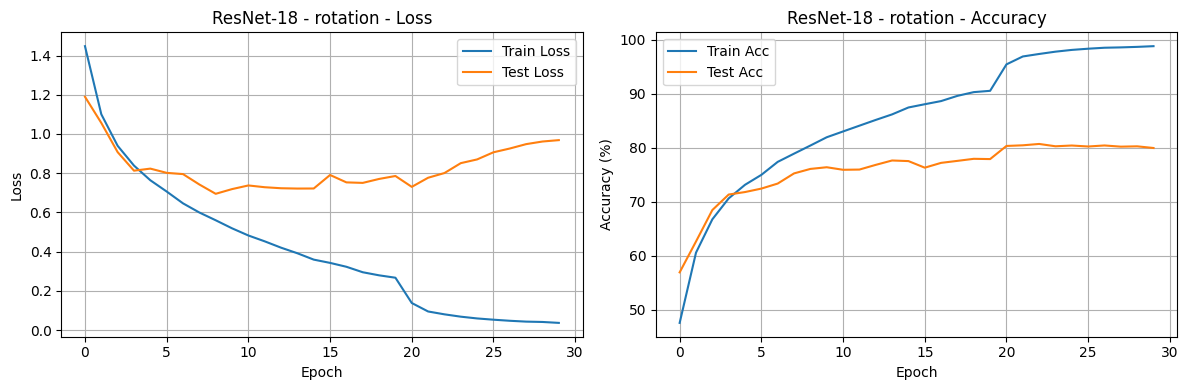


>> 实验: random_crop
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 48.36% | Test Acc: 61.04%
Epoch 2/30 | Train Acc: 62.68% | Test Acc: 62.71%
Epoch 3/30 | Train Acc: 68.20% | Test Acc: 68.08%
Epoch 4/30 | Train Acc: 72.35% | Test Acc: 68.95%
Epoch 5/30 | Train Acc: 75.17% | Test Acc: 71.98%
Epoch 6/30 | Train Acc: 77.10% | Test Acc: 73.98%
Epoch 7/30 | Train Acc: 79.01% | Test Acc: 75.45%
Epoch 8/30 | Train Acc: 81.00% | Test Acc: 75.34%
Epoch 9/30 | Train Acc: 82.42% | Test Acc: 76.29%
Epoch 10/30 | Train Acc: 83.61% | Test Acc: 76.13%
Epoch 11/30 | Train Acc: 84.85% | Test Acc: 76.45%
Epoch 12/30 | Train Acc: 86.03% | Test Acc: 77.12%
Epoch 13/30 | Train Acc: 86.98% | Test Acc: 77.12%
Epoch 14/30 | Train Acc: 88.07% | Test Acc: 77.10%
Epoch 15/30 | Train Acc: 88.60% | Test Acc: 77.78%
Epoch 16/30 | Train Acc: 89.50% | Test Acc: 77.34%
Epoch 17/30 | Train Acc: 89.98% | Test Acc: 76.74%
Epoch 18/30 | Train Acc: 90.64% | Test Acc: 78

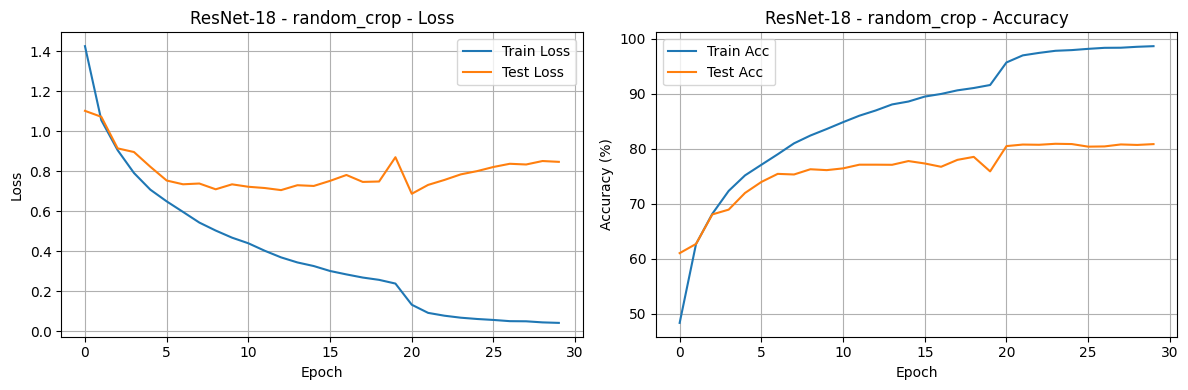


>> 实验: color_jitter
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 49.03% | Test Acc: 57.45%
Epoch 2/30 | Train Acc: 64.49% | Test Acc: 67.17%
Epoch 3/30 | Train Acc: 70.58% | Test Acc: 70.35%
Epoch 4/30 | Train Acc: 75.14% | Test Acc: 72.68%
Epoch 5/30 | Train Acc: 78.64% | Test Acc: 73.74%
Epoch 6/30 | Train Acc: 81.66% | Test Acc: 73.15%
Epoch 7/30 | Train Acc: 84.17% | Test Acc: 72.92%
Epoch 8/30 | Train Acc: 86.54% | Test Acc: 75.39%
Epoch 9/30 | Train Acc: 88.53% | Test Acc: 75.05%
Epoch 10/30 | Train Acc: 90.22% | Test Acc: 75.85%
Epoch 11/30 | Train Acc: 91.64% | Test Acc: 75.27%
Epoch 12/30 | Train Acc: 93.00% | Test Acc: 75.35%
Epoch 13/30 | Train Acc: 93.74% | Test Acc: 74.22%
Epoch 14/30 | Train Acc: 94.13% | Test Acc: 75.69%
Epoch 15/30 | Train Acc: 94.94% | Test Acc: 75.02%
Epoch 16/30 | Train Acc: 95.39% | Test Acc: 75.15%
Epoch 17/30 | Train Acc: 95.70% | Test Acc: 75.27%
Epoch 18/30 | Train Acc: 95.76% | Test Acc: 7

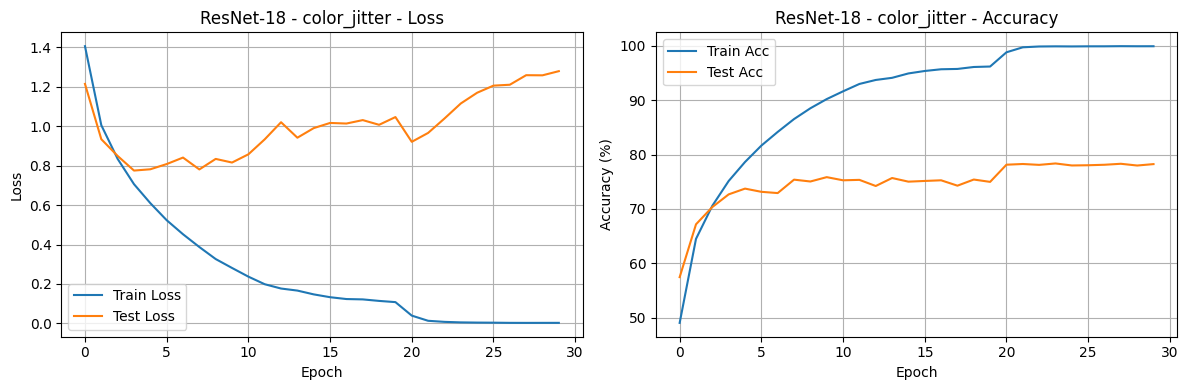


>> 实验: random_erasing
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 48.17% | Test Acc: 58.15%
Epoch 2/30 | Train Acc: 60.66% | Test Acc: 65.07%
Epoch 3/30 | Train Acc: 66.57% | Test Acc: 67.33%
Epoch 4/30 | Train Acc: 69.86% | Test Acc: 68.08%
Epoch 5/30 | Train Acc: 72.60% | Test Acc: 72.93%
Epoch 6/30 | Train Acc: 74.66% | Test Acc: 73.01%
Epoch 7/30 | Train Acc: 76.71% | Test Acc: 74.35%
Epoch 8/30 | Train Acc: 78.53% | Test Acc: 74.03%
Epoch 9/30 | Train Acc: 80.24% | Test Acc: 75.36%
Epoch 10/30 | Train Acc: 81.49% | Test Acc: 72.15%
Epoch 11/30 | Train Acc: 82.39% | Test Acc: 77.13%
Epoch 12/30 | Train Acc: 83.99% | Test Acc: 76.00%
Epoch 13/30 | Train Acc: 85.03% | Test Acc: 77.50%
Epoch 14/30 | Train Acc: 85.94% | Test Acc: 76.35%
Epoch 15/30 | Train Acc: 86.81% | Test Acc: 76.40%
Epoch 16/30 | Train Acc: 87.88% | Test Acc: 76.20%
Epoch 17/30 | Train Acc: 88.35% | Test Acc: 76.40%
Epoch 18/30 | Train Acc: 88.81% | Test Acc:

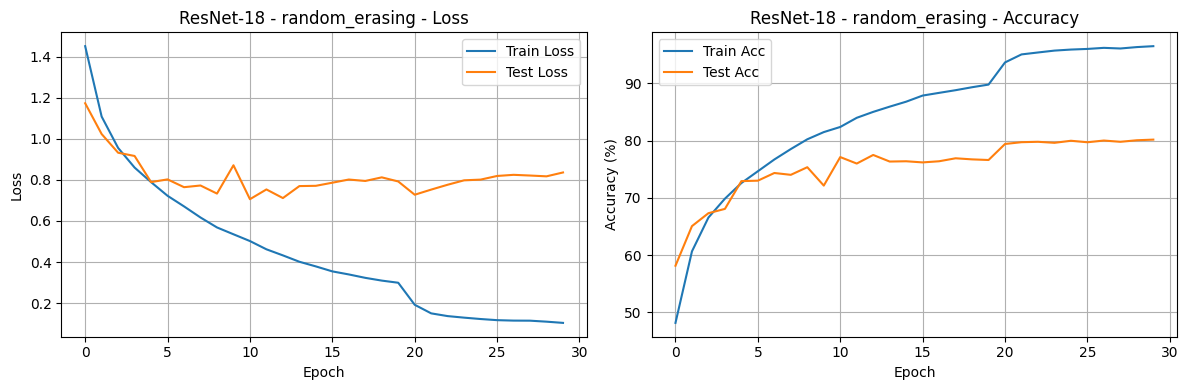


>> 实验: geo_color_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 47.86% | Test Acc: 57.63%
Epoch 2/30 | Train Acc: 61.59% | Test Acc: 65.61%
Epoch 3/30 | Train Acc: 66.71% | Test Acc: 68.16%
Epoch 4/30 | Train Acc: 70.23% | Test Acc: 70.54%
Epoch 5/30 | Train Acc: 72.87% | Test Acc: 72.03%
Epoch 6/30 | Train Acc: 75.13% | Test Acc: 75.12%
Epoch 7/30 | Train Acc: 76.46% | Test Acc: 75.41%
Epoch 8/30 | Train Acc: 77.75% | Test Acc: 77.01%
Epoch 9/30 | Train Acc: 78.97% | Test Acc: 77.47%
Epoch 10/30 | Train Acc: 79.97% | Test Acc: 76.93%
Epoch 11/30 | Train Acc: 80.84% | Test Acc: 78.44%
Epoch 12/30 | Train Acc: 81.74% | Test Acc: 78.08%
Epoch 13/30 | Train Acc: 82.29% | Test Acc: 78.76%
Epoch 14/30 | Train Acc: 83.10% | Test Acc: 78.92%
Epoch 15/30 | Train Acc: 84.01% | Test Acc: 79.51%
Epoch 16/30 | Train Acc: 84.22% | Test Acc: 80.14%
Epoch 17/30 | Train Acc: 85.09% | Test Acc: 79.93%
Epoch 18/30 | Train Acc: 85.51% | Test Acc

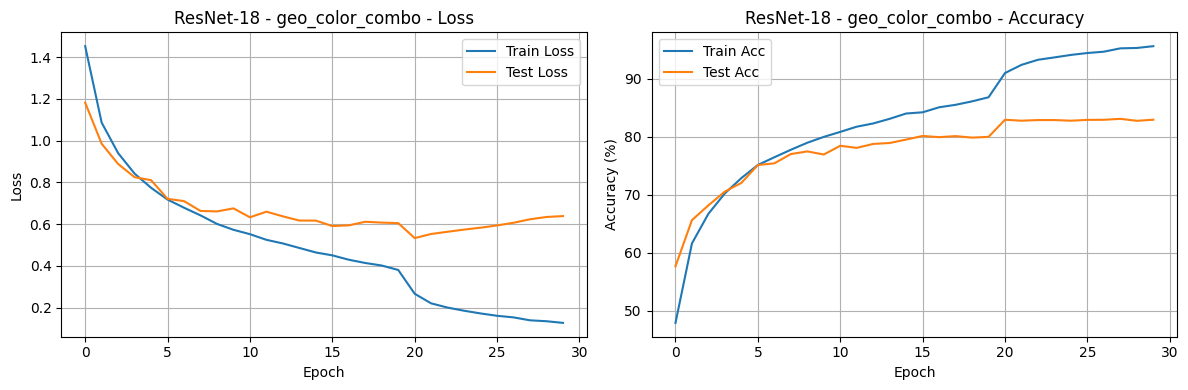


>> 实验: geo_erase_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 47.23% | Test Acc: 56.99%
Epoch 2/30 | Train Acc: 59.84% | Test Acc: 63.16%
Epoch 3/30 | Train Acc: 65.00% | Test Acc: 68.90%
Epoch 4/30 | Train Acc: 68.44% | Test Acc: 70.14%
Epoch 5/30 | Train Acc: 70.84% | Test Acc: 72.36%
Epoch 6/30 | Train Acc: 72.45% | Test Acc: 74.53%
Epoch 7/30 | Train Acc: 74.15% | Test Acc: 74.60%
Epoch 8/30 | Train Acc: 75.08% | Test Acc: 76.32%
Epoch 9/30 | Train Acc: 76.31% | Test Acc: 75.56%
Epoch 10/30 | Train Acc: 77.03% | Test Acc: 76.38%
Epoch 11/30 | Train Acc: 77.77% | Test Acc: 76.79%
Epoch 12/30 | Train Acc: 78.57% | Test Acc: 77.22%
Epoch 13/30 | Train Acc: 79.41% | Test Acc: 78.81%
Epoch 14/30 | Train Acc: 80.09% | Test Acc: 78.62%
Epoch 15/30 | Train Acc: 80.45% | Test Acc: 78.71%
Epoch 16/30 | Train Acc: 80.82% | Test Acc: 77.20%
Epoch 17/30 | Train Acc: 81.30% | Test Acc: 77.93%
Epoch 18/30 | Train Acc: 81.95% | Test Acc

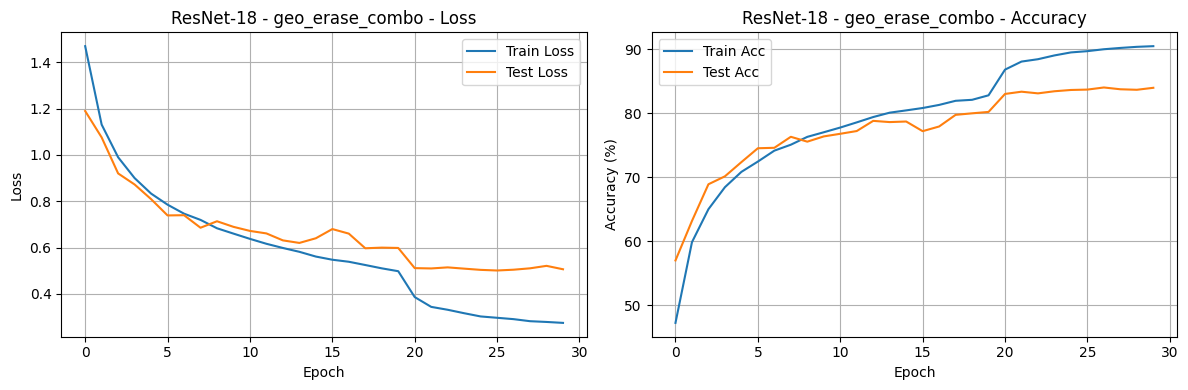


>> 实验: comprehensive_combo
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 43.25% | Test Acc: 52.75%
Epoch 2/30 | Train Acc: 55.79% | Test Acc: 61.22%
Epoch 3/30 | Train Acc: 61.75% | Test Acc: 66.63%
Epoch 4/30 | Train Acc: 65.03% | Test Acc: 67.64%
Epoch 5/30 | Train Acc: 67.24% | Test Acc: 70.15%
Epoch 6/30 | Train Acc: 69.04% | Test Acc: 72.90%
Epoch 7/30 | Train Acc: 70.88% | Test Acc: 72.59%
Epoch 8/30 | Train Acc: 72.19% | Test Acc: 74.50%
Epoch 9/30 | Train Acc: 72.99% | Test Acc: 75.59%
Epoch 10/30 | Train Acc: 73.99% | Test Acc: 75.55%
Epoch 11/30 | Train Acc: 74.88% | Test Acc: 76.46%
Epoch 12/30 | Train Acc: 75.42% | Test Acc: 76.88%
Epoch 13/30 | Train Acc: 76.20% | Test Acc: 78.25%
Epoch 14/30 | Train Acc: 76.73% | Test Acc: 77.09%
Epoch 15/30 | Train Acc: 77.25% | Test Acc: 78.92%
Epoch 16/30 | Train Acc: 77.80% | Test Acc: 78.54%
Epoch 17/30 | Train Acc: 78.54% | Test Acc: 78.14%
Epoch 18/30 | Train Acc: 78.76% | Test

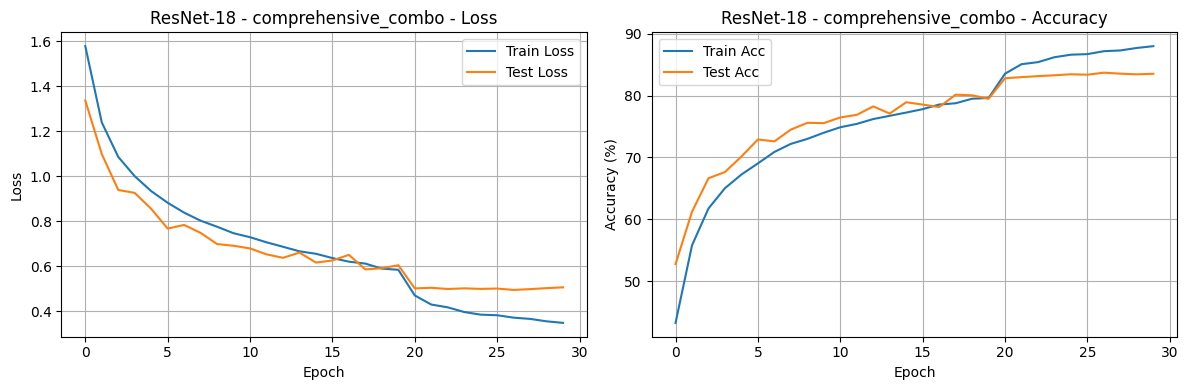

In [15]:
# ========== 8. 主实验执行 ==========

# 8.1 准备各种变换
baseline_transform       = get_baseline_transform()
single_transforms        = get_single_augmentation_transforms()
combo_transforms         = get_combination_augmentation_transforms()
sensitivity_transforms   = get_parameter_sensitivity_transforms()

test_transform = baseline_transform  # 测试集统一使用基线变换

# 8.2 构建实验列表：('增强名称', train_transform)
experiments = [('baseline', baseline_transform)]
for name, tf in single_transforms.items():
    experiments.append((name, tf))
for name, tf in combo_transforms.items():
    experiments.append((name, tf))

# 存储结果的字典
all_results = {'SimpleCNN':[], 'ResNet-18':[]}

# 8.3 对每个模型和每种增强策略依次进行训练、评估
for model_name in ['SimpleCNN', 'ResNet-18']:
    print(f"\n====== 训练 & 评估: {model_name} ======")
    for aug_name, train_tf in experiments:
        print(f"\n>> 实验: {aug_name}")
        train_loader, test_loader = get_cifar10_loaders(train_tf, test_transform, batch_size)

        # 初始化模型
        if model_name == 'SimpleCNN':
            model = SimpleCNN(num_classes=10)
        else:
            model = get_resnet18(num_classes=10)

        # 训练
        start = time.time()
        trained_model, hist = train_model(model, train_loader, test_loader, num_epochs, learning_rate)
        train_time = time.time() - start

        # 评估
        eval_res = evaluate_model(trained_model, test_loader)

        # 保存结果
        all_results[model_name].append({
            'augmentation': aug_name,
            'accuracy': eval_res['overall_accuracy'],
            'training_time': train_time,
            'inference_time': eval_res['inference_time'],
            'final_loss': hist['test_loss'][-1],
            'best_test_acc': max(hist['test_acc'])
        })

        # 绘制当前实验的训练曲线
        plot_training_history(hist, f"{model_name} - {aug_name}")

        # 释放显存
        del model, trained_model
        if torch.cuda.is_available(): torch.cuda.empty_cache()



====== 参数敏感性分析（旋转角度） ======

>> 参数: rotation_5deg
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 48.84% | Test Acc: 57.95%
Epoch 2/30 | Train Acc: 61.75% | Test Acc: 68.11%
Epoch 3/30 | Train Acc: 66.84% | Test Acc: 70.34%
Epoch 4/30 | Train Acc: 69.78% | Test Acc: 73.43%
Epoch 5/30 | Train Acc: 72.20% | Test Acc: 74.95%
Epoch 6/30 | Train Acc: 74.13% | Test Acc: 74.40%
Epoch 7/30 | Train Acc: 75.40% | Test Acc: 75.81%
Epoch 8/30 | Train Acc: 76.70% | Test Acc: 75.96%
Epoch 9/30 | Train Acc: 77.78% | Test Acc: 76.36%
Epoch 10/30 | Train Acc: 78.82% | Test Acc: 77.02%
Epoch 11/30 | Train Acc: 80.17% | Test Acc: 79.28%
Epoch 12/30 | Train Acc: 80.95% | Test Acc: 78.95%
Epoch 13/30 | Train Acc: 81.87% | Test Acc: 79.25%
Epoch 14/30 | Train Acc: 82.72% | Test Acc: 79.57%
Epoch 15/30 | Train Acc: 83.55% | Test Acc: 79.69%
Epoch 16/30 | Train Acc: 84.14% | Test Acc: 80.10%
Epoch 17/30 | Train Acc: 84.68% | Test Acc: 80.06%
Epoch 18/30 | T

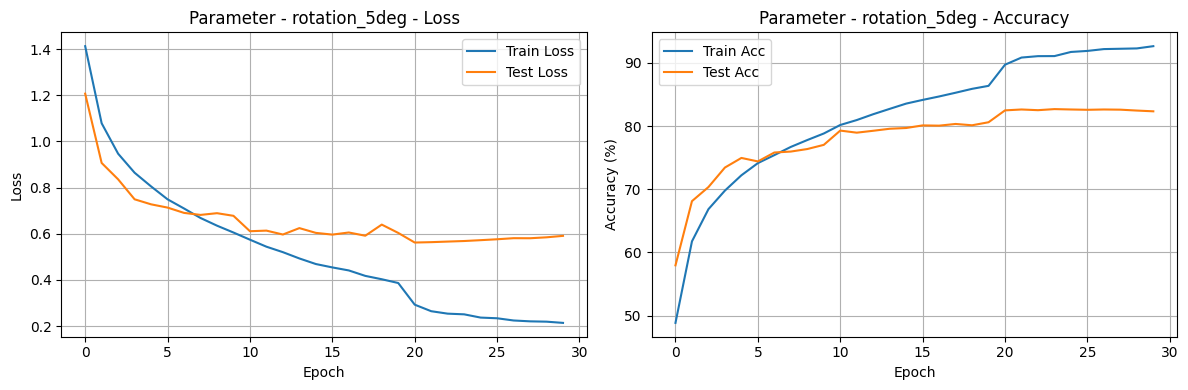


>> 参数: rotation_15deg
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 44.20% | Test Acc: 58.71%
Epoch 2/30 | Train Acc: 57.50% | Test Acc: 64.93%
Epoch 3/30 | Train Acc: 62.08% | Test Acc: 69.94%
Epoch 4/30 | Train Acc: 65.47% | Test Acc: 70.48%
Epoch 5/30 | Train Acc: 67.32% | Test Acc: 73.44%
Epoch 6/30 | Train Acc: 69.29% | Test Acc: 72.53%
Epoch 7/30 | Train Acc: 70.66% | Test Acc: 74.96%
Epoch 8/30 | Train Acc: 71.66% | Test Acc: 74.57%
Epoch 9/30 | Train Acc: 73.00% | Test Acc: 76.08%
Epoch 10/30 | Train Acc: 73.70% | Test Acc: 76.87%
Epoch 11/30 | Train Acc: 74.68% | Test Acc: 78.25%
Epoch 12/30 | Train Acc: 75.36% | Test Acc: 77.60%
Epoch 13/30 | Train Acc: 76.35% | Test Acc: 77.69%
Epoch 14/30 | Train Acc: 76.67% | Test Acc: 79.35%
Epoch 15/30 | Train Acc: 77.34% | Test Acc: 78.12%
Epoch 16/30 | Train Acc: 78.15% | Test Acc: 79.10%
Epoch 17/30 | Train Acc: 78.68% | Test Acc: 78.51%
Epoch 18/30 | Train Acc: 79.30% | Test Acc:

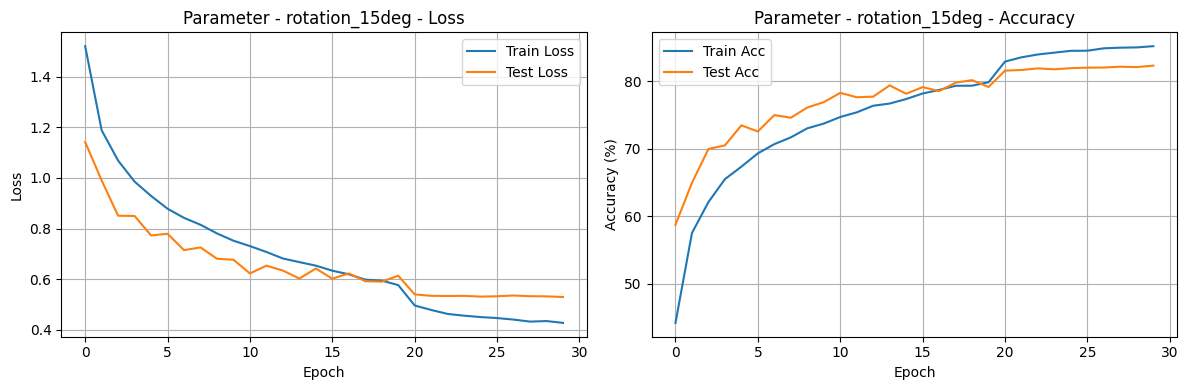


>> 参数: rotation_30deg
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/30 | Train Acc: 43.07% | Test Acc: 52.56%
Epoch 2/30 | Train Acc: 53.59% | Test Acc: 61.86%
Epoch 3/30 | Train Acc: 58.11% | Test Acc: 65.31%
Epoch 4/30 | Train Acc: 61.11% | Test Acc: 68.86%
Epoch 5/30 | Train Acc: 63.58% | Test Acc: 69.17%
Epoch 6/30 | Train Acc: 64.95% | Test Acc: 72.16%
Epoch 7/30 | Train Acc: 66.66% | Test Acc: 72.99%
Epoch 8/30 | Train Acc: 67.67% | Test Acc: 73.35%
Epoch 9/30 | Train Acc: 68.92% | Test Acc: 74.00%
Epoch 10/30 | Train Acc: 69.70% | Test Acc: 75.07%
Epoch 11/30 | Train Acc: 70.55% | Test Acc: 74.00%
Epoch 12/30 | Train Acc: 71.56% | Test Acc: 76.14%
Epoch 13/30 | Train Acc: 72.05% | Test Acc: 76.40%
Epoch 14/30 | Train Acc: 72.70% | Test Acc: 77.19%
Epoch 15/30 | Train Acc: 73.20% | Test Acc: 77.42%
Epoch 16/30 | Train Acc: 73.96% | Test Acc: 77.73%
Epoch 17/30 | Train Acc: 74.51% | Test Acc: 77.27%
Epoch 18/30 | Train Acc: 75.02% | Test Acc:

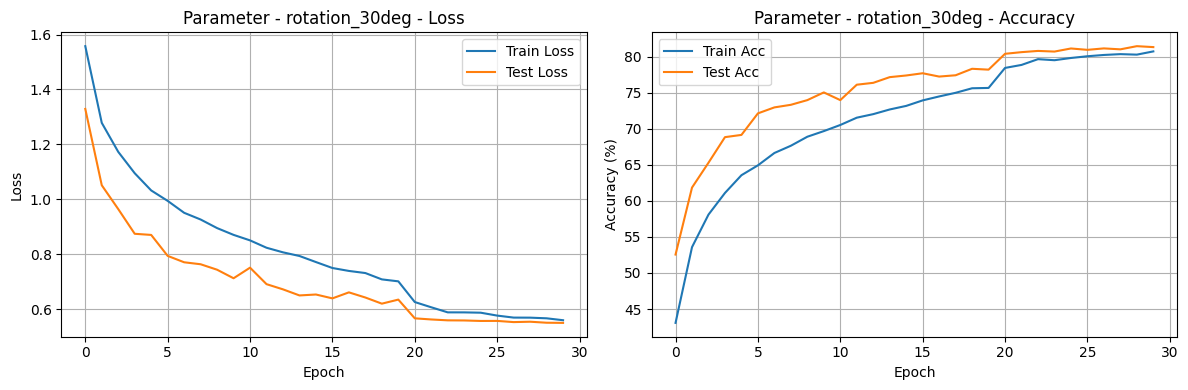

In [16]:
# ========== 9. 参数敏感性分析 ==========
print("\n====== 参数敏感性分析（旋转角度） ======")
sensitivity_results = []

for param_name, train_tf in sensitivity_transforms.items():
    print(f"\n>> 参数: {param_name}")
    train_loader, test_loader = get_cifar10_loaders(train_tf, baseline_transform, batch_size)
    model = SimpleCNN(num_classes=10)

    start = time.time()
    trained_model, hist = train_model(model, train_loader, test_loader, num_epochs, learning_rate)
    train_time = time.time() - start

    eval_res = evaluate_model(trained_model, test_loader)
    sensitivity_results.append({
        'parameter_setting': param_name,
        'accuracy': eval_res['overall_accuracy'],
        'training_time': train_time,
        'final_loss': hist['test_loss'][-1]
    })

    plot_training_history(hist, f"Parameter - {param_name}")
    del model, trained_model
    if torch.cuda.is_available(): torch.cuda.empty_cache()


----- SimpleCNN 结果表 -----


,augmentation,accuracy,training_time,inference_time,final_loss,best_test_acc
0,baseline,81.87,215.269,1.701,0.738,81.87
1,horizontal_flip,84.19,232.694,1.350,0.503,84.19
2,rotation,82.95,260.202,1.863,0.503,82.95
3,random_crop,83.22,333.602,1.644,0.526,83.22
4,color_jitter,81.27,426.068,1.452,0.731,81.27
5,random_erasing,82.14,273.438,1.475,0.569,82.14
6,geo_color_combo,83.82,497.344,1.855,0.472,83.82
7,geo_erase_combo,82.20,389.584,1.868,0.513,82.20
8,comprehensive_combo,82.50,667.100,1.373,0.501,82.50


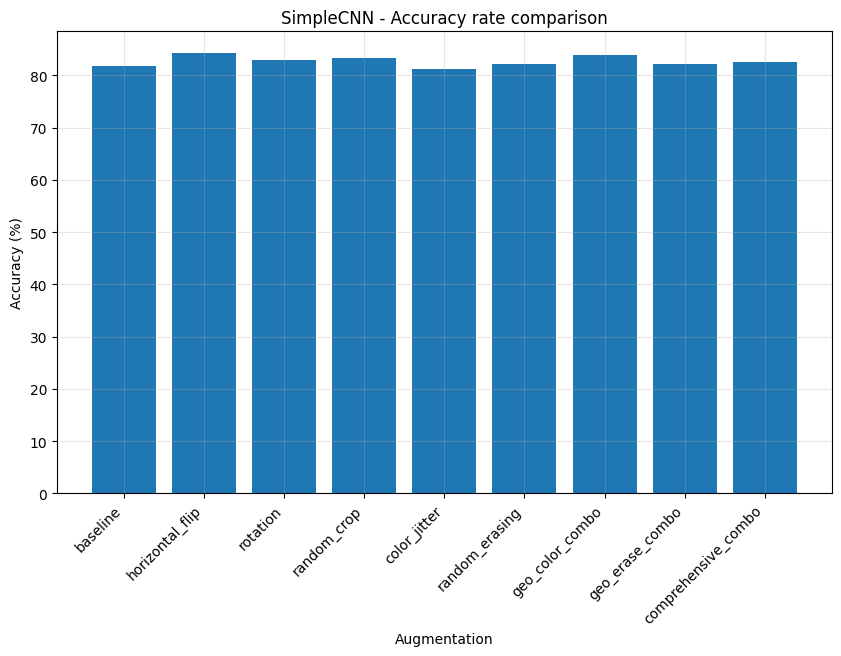

----- ResNet-18 结果表 -----


,augmentation,accuracy,training_time,inference_time,final_loss,best_test_acc
0,baseline,78.52,394.756,1.661,1.339,78.52
1,horizontal_flip,82.09,389.497,1.726,1.026,82.09
2,rotation,80.72,382.257,1.711,0.969,80.72
3,random_crop,80.92,385.629,1.688,0.847,80.92
4,color_jitter,78.37,430.528,1.965,1.280,78.37
5,random_erasing,80.18,381.536,1.733,0.836,80.18
6,geo_color_combo,83.09,496.913,2.169,0.639,83.09
7,geo_erase_combo,84.03,416.977,1.696,0.506,84.03
8,comprehensive_combo,83.70,630.358,2.189,0.506,83.70


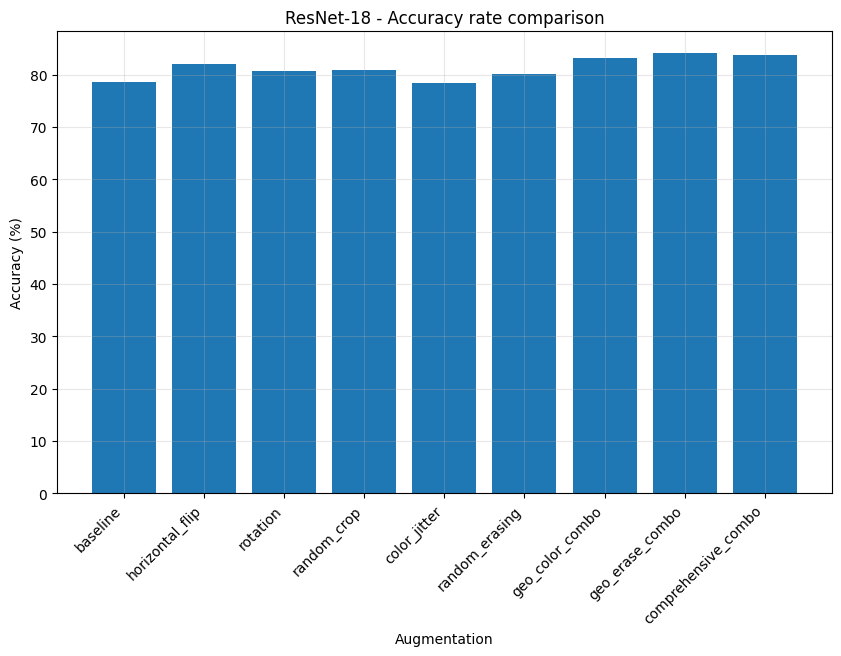

----- 参数敏感性分析结果 -----


,parameter_setting,accuracy,training_time,final_loss
0,rotation_5deg,82.68,261.581,0.591
1,rotation_15deg,82.28,259.342,0.530
2,rotation_30deg,81.49,263.106,0.550


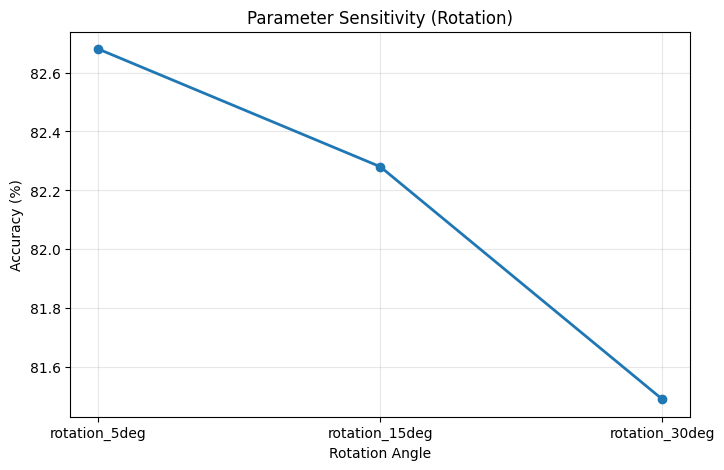

In [30]:
# ========== 10. 结果汇总与可视化 ==========

import pandas as pd

def to_dataframe(results_list):
    return pd.DataFrame(results_list).round(3)

# 10.1 SimpleCNN 结果
df_simple = to_dataframe(all_results['SimpleCNN'])
print("----- SimpleCNN 结果表 -----")
display(df_simple)  # Jupyter 会以表格形式展示

# 绘制对比图
plot_augmentation_comparison(df_simple, 'SimpleCNN')

# 10.2 ResNet-18 结果
df_resnet = to_dataframe(all_results['ResNet-18'])
print("----- ResNet-18 结果表 -----")
display(df_resnet)
plot_augmentation_comparison(df_resnet, 'ResNet-18')

# 10.3 参数敏感性结果
df_sensitivity = pd.DataFrame(sensitivity_results).round(3)
print("----- 参数敏感性分析结果 -----")
display(df_sensitivity)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(df_sensitivity['parameter_setting'], df_sensitivity['accuracy'], 'o-', linewidth=2, markersize=6)
plt.xlabel("Rotation Angle")
plt.ylabel("Accuracy (%)")
plt.title("Parameter Sensitivity (Rotation)")
plt.grid(alpha=0.3)
plt.show()
